> **Problem overview**

"Quick, Draw!" was released as an experimental game to educate the public in a playful way about how AI works. The game prompts users to draw an image depicting a certain category, such as ”banana,” “table,” etc. The game generated more than 1B drawings, of which a subset was publicly released as the basis for this competition’s training set. That subset contains 50M drawings encompassing 340 label categories.

Sounds fun, right? Here's the challenge: since the training data comes from the game itself, drawings can be incomplete or may not match the label. You’ll need to build a recognizer that can effectively learn from this noisy data and perform well on a manually-labeled test set from a different distribution.

Your task is to build a better classifier for the existing Quick, Draw! dataset. By advancing models on this dataset, Kagglers can improve pattern recognition solutions more broadly. This will have an immediate impact on handwriting recognition and its robust applications in areas including OCR (Optical Character Recognition), ASR (Automatic Speech Recognition) & NLP (Natural Language Processing).

In [1]:
# import python standard library
import ast, os

# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
from tqdm import tqdm

# import image processing library
import cv2

# import tensorflow model class
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import load_model, Sequential

# import sklearn model selection
from sklearn.model_selection import train_test_split

# import tensorflow model evaluation classification metrics
from tensorflow.keras.metrics import top_k_categorical_accuracy

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
df_train = pd.concat([pd.read_csv('../input/train_simplified/' + file, nrows=4) for file in os.listdir('../input/train_simplified')], ignore_index=True)
df_test = pd.read_csv('../input/test_simplified.csv', nrows=2)

In [3]:
# visualize head of the training data
df_train.head(n=5)

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[91, 73, 53, 31, 26, 24], [255, 251, 235, 18...",5940792512217088,True,2017-03-22 17:41:18.806040,stethoscope
1,US,"[[[17, 5, 0, 0, 18, 43, 74, 95, 135, 139, 142,...",5817564116549632,True,2017-01-26 14:30:44.006860,stethoscope
2,PL,"[[[25, 3, 0, 6, 22, 30], [0, 28, 68, 86, 108, ...",5120884597587968,True,2017-03-25 08:47:49.593220,stethoscope
3,KR,"[[[0, 17, 28, 21, 1, 3, 7], [15, 3, 20, 30, 30...",6576621114884096,True,2017-03-21 08:32:46.290940,stethoscope
4,US,"[[[62, 66, 91, 121, 159, 200, 218, 232, 246, 2...",6120310522773504,True,2017-01-31 15:39:43.366540,fan


In [4]:
# visualize tail of the testing data
df_test.tail(n=5)

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."


In [5]:
# dataframe columns name
names = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

# class files and dictionary
files = sorted([file.lower() for file in os.listdir('../input/train_simplified/')], reverse=False)
class_dict = {file[:-4].replace(" ", "_"): i for i, file in enumerate(files)}
classreverse_dict = {v: k for k, v in class_dict.items()}

# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_train = df_train[['key_id', 'countrycode', 'drawing', 'datatype', 'word', 'recognized']]
df_test['word'], df_test['recognized'] = '', True
df_data = pd.concat([df_train, df_test], ignore_index=True)

In [6]:
# data dimensions
img_size = 32
num_channels = 1
num_classes = 340

# flat dimensions
img_size_flat = img_size * img_size * num_channels

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [7]:
# drawplot function plot
def drawplot(drawing = None, label = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i in label.index:
        for j in range(len(drawing[i])): _ = axes[i - label.index[0]].plot(drawing[i][j][0], drawing[i][j][1])
        axes[i - label.index[0]].invert_yaxis()
        axes[i - label.index[0]].set_title(label[i])

In [8]:
# imageplot function plot
def imageplot(pixel = None, label = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i in range(len(label)): axes[i].imshow(pixel[i].reshape(img_size, img_size), interpolation='spline16')

In [9]:
# feature exploration, engineering and cleansing
def feature_extraction(df_data):
    # feature extraction: drawing
    df_data['drawing'] = df_data['drawing'].apply(lambda x: ast.literal_eval(x))
    
    # feature extraction: word
    df_data['word'] = df_data['word'].apply(lambda x: x.lower().replace(' ', '_'))
    
    # feature extraction: drawing to pixel
    def drawing2pixel(drawing = None):
        image = np.zeros((256, 256))
        for stroke in drawing:
            for i in range(len(stroke[0])-1):
                _ = cv2.line(image, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), color=1, thickness=5)
        return cv2.resize(image, (img_size, img_size))
    df_data['pixel'] = df_data['drawing'].apply(lambda x: drawing2pixel(x))
    
    return df_data

In [10]:
# feature extraction: step 1
df_data = feature_extraction(df_data)

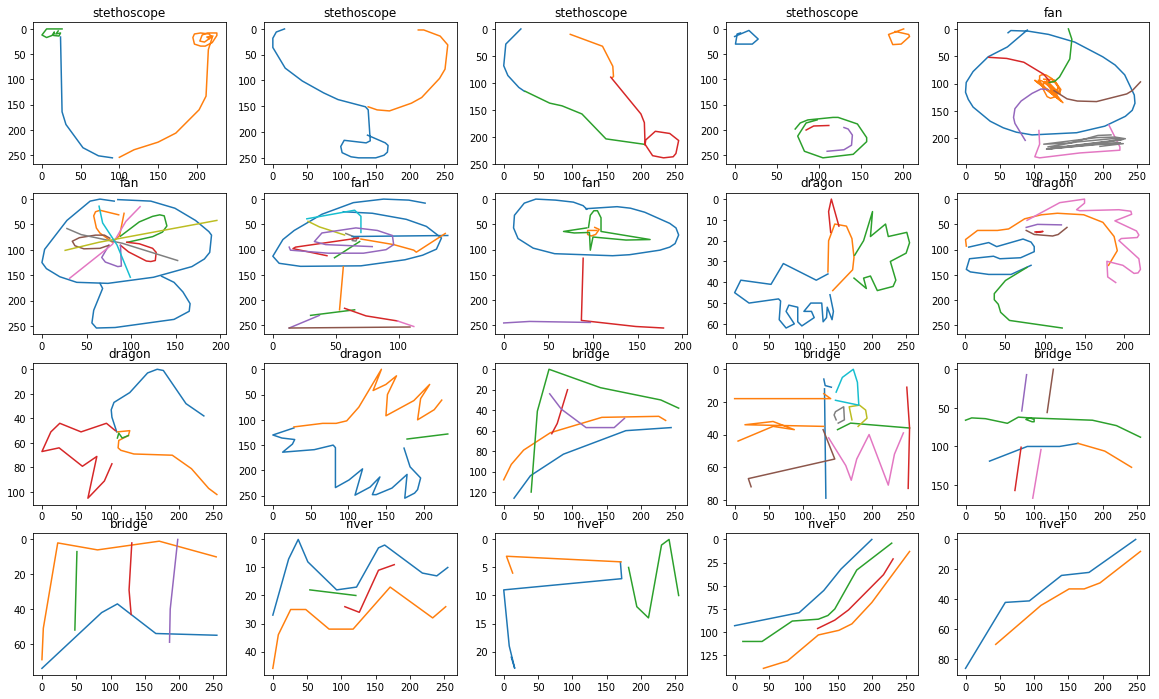

In [11]:
# feature exploration: image
drawplot(df_data.loc[:19, 'drawing'], df_data.loc[:19, 'word'], nrows=4)

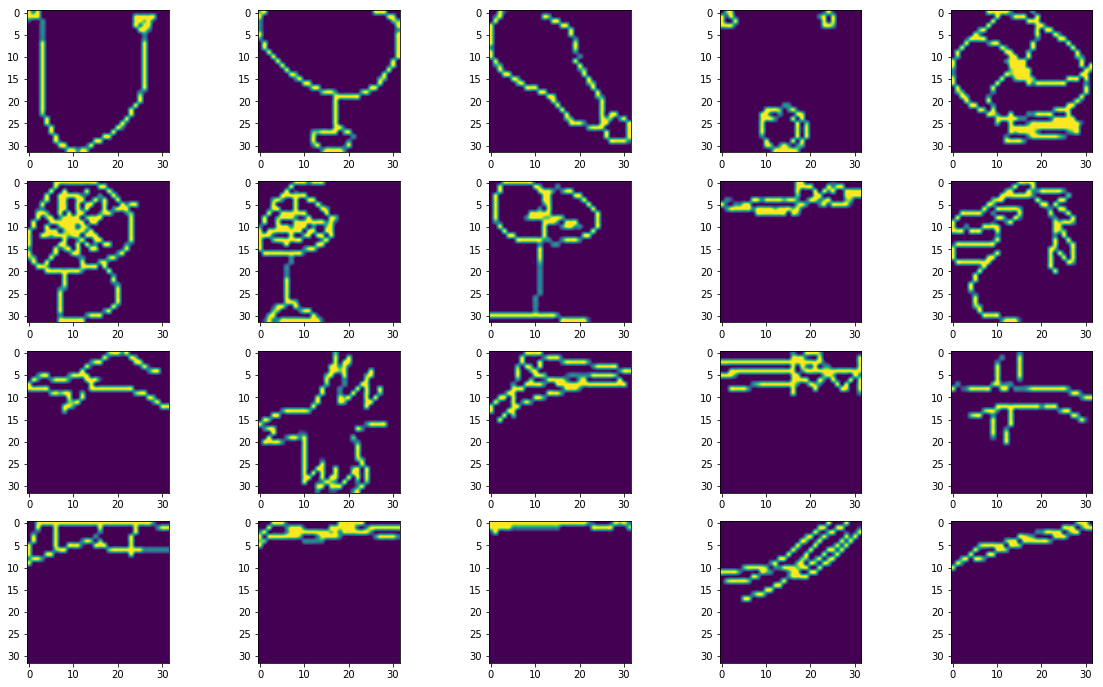

In [12]:
# feature exploration: image
imageplot(df_data.loc[:19, 'pixel'], df_data.loc[:19, 'word'], nrows=4)

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [13]:
# feature exploration, engineering and cleansing
def feature_extraction2(df_data):
    # feature extraction: remove countrycode and drawing
    df_data = df_data.drop(['countrycode', 'drawing'], axis=1)
    
    # convert category codes for data dataframe
    df_data = pd.get_dummies(df_data, columns=['datatype', 'word'], drop_first=False)
    
    return df_data

In [14]:
# feature extraction: step 2
df_data = feature_extraction2(df_data)

In [15]:
# describe data dataframe
df_data.describe(include='all')

,key_id,recognized,pixel,datatype_testing,datatype_training,word_,word_airplane,word_alarm_clock,word_ambulance,word_angel,word_animal_migration,word_ant,word_anvil,word_apple,word_arm,word_asparagus,word_axe,word_backpack,word_banana,word_bandage,word_barn,word_baseball,word_baseball_bat,word_basket,word_basketball,word_bat,word_bathtub,word_beach,word_bear,word_beard,word_bed,word_bee,word_belt,word_bench,word_bicycle,word_binoculars,word_bird,word_birthday_cake,word_blackberry,word_blueberry,...,word_telephone,word_television,word_tennis_racquet,word_tent,word_the_eiffel_tower,word_the_great_wall_of_china,word_the_mona_lisa,word_tiger,word_toaster,word_toe,word_toilet,word_tooth,word_toothbrush,word_toothpaste,word_tornado,word_tractor,word_traffic_light,word_train,word_tree,word_triangle,word_trombone,word_truck,word_trumpet,word_umbrella,word_underwear,word_van,word_vase,word_violin,word_washing_machine,word_watermelon,word_waterslide,word_whale,word_wheel,word_windmill,word_wine_bottle,word_wine_glass,word_wristwatch,word_yoga,word_zebra,word_zigzag
count,1.362000e+03,1362,1362,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,...,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000
unique,NaN,2,1362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,"[[0.5, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.604385e+15,NaN,NaN,0.001468,0.998532,0.001468,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,...,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937,0.002937
std,6.575316e+14,NaN,NaN,0.038306,0.038306,0.038306,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133,0.054133

In [16]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Columns: 346 entries, key_id to word_zigzag
dtypes: bool(1), int64(1), object(1), uint8(343)
memory usage: 478.9+ KB


In [17]:
# memory clean-up
del df_data, df_train, df_test

In [18]:
# acquiring training data
list_of_data = []
for row in tqdm(range(1, 512, 64)):
    # acquiring training data
    df_data = pd.concat([pd.read_csv('../input/train_simplified/' + file, names=names, nrows=64, skiprows=row) for file in os.listdir('../input/train_simplified')], ignore_index=True)
    
    # combine training dataframe
    df_data['datatype'] = 'training'
    df_data = df_data[['key_id', 'countrycode', 'drawing', 'datatype', 'word', 'recognized']]
    
    # feature extraction: step 1
    df_data = feature_extraction(df_data)
    
    # feature extraction: step 2
    df_data = feature_extraction2(df_data)
    
    # feature extraction: append data dataframe
    list_of_data.append(df_data)
df_data = pd.concat(list_of_data, ignore_index=True)

100%|██████████| 8/8 [01:36<00:00, 12.23s/it]


> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [19]:
# select all features
x = np.zeros((df_data.shape[0], img_size, img_size, 1))
for i, df_row in df_data.iterrows(): x[i, :, :, 0] = df_row['pixel']
y = df_data[[col for col in df_data if col.startswith('word')]]

In [20]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=58, test_size=0.10)

In [21]:
# memory clean-up
del df_data, x, y

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A loss measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In [22]:
# top_3_categorical_accuracy function
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [23]:
# keras model setup
model_keras = Sequential()
model_keras.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
model_keras.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model_keras.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model_keras.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model_keras.add(Dropout(rate=0.2, seed=58))
model_keras.add(Flatten())
model_keras.add(Dense(680, activation='relu'))
model_keras.add(Dropout(rate=0.5, seed=58))
model_keras.add(Dense(num_classes, activation='softmax'))
model_keras.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)    

In [24]:
# keras model setup
model_keras.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[top_3_categorical_accuracy])

# keras model fit
model_keras.fit(x_train, y_train, batch_size=32, epochs=32, verbose=2, validation_data=(x_validate, y_validate))

# keras model metrics
model_keras_score = model_keras.evaluate(x_validate, y_validate, verbose=1)
print('keras\n  top 3 categorical accuracy score: %0.4f' %model_keras_score[1])

Train on 156672 samples, validate on 17408 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/32
 - 295s - loss: 3.5742 - top_3_categorical_accuracy: 0.4175 - val_loss: 2.6090 - val_top_3_categorical_accuracy: 0.6211
Epoch 2/32
 - 296s - loss: 2.6846 - top_3_categorical_accuracy: 0.5949 - val_loss: 2.2798 - val_top_3_categorical_accuracy: 0.6793
Epoch 3/32
 - 293s - loss: 2.4051 - top_3_categorical_accuracy: 0.6475 - val_loss: 2.1380 - val_top_3_categorical_accuracy: 0.7035
Epoch 4/32
 - 294s - loss: 2.2309 - top_3_categorical_accuracy: 0.6804 - val_loss: 2.0700 - val_top_3_categorical_accuracy: 0.7124
Epoch 5/32
 - 291s - loss: 2.1070 - top_3_categorical_accuracy: 0.7027 - val_loss: 2.0190 - val_top_3_categorical_accuracy: 0.7244
Epoch 6/32
 - 293s - loss: 1.9970 - top_3_categorical_accuracy: 0.7237 - val_loss: 2.0126 - val_top_3_categorical_accuracy: 0.7272
Epoch 7/32
 - 295s - loss: 1.9108 - top_3_categorical_accuracy: 0.7375 - val_loss: 1.9809 - val_top_3_categorical_a

In [25]:
# keras model save
model_keras.save('model_keras.h5')

In [26]:
# memory clean-up
del x_train, x_validate, y_train, y_validate

> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [27]:
# acquiring testing data
df_test = pd.read_csv('../input/test_simplified.csv')

# combine testing dataframe
df_test['datatype'] = 'testing'
df_test['word'], df_test['recognized'] = '', True

# feature extraction: step 1
df_test = feature_extraction(df_test)

# feature extraction: step 2
df_test = feature_extraction2(df_test)

In [28]:
# prepare testing data and compute the observed value
x_test = np.zeros((df_test.shape[0], img_size, img_size, 1))
for i, df_row in df_test.iterrows(): x_test[i, :, :, 0] = df_row['pixel']
y_test = np.argsort(-model_keras.predict(x_test, verbose=1))[:, 0:3]
df_word = pd.DataFrame({'top 1': y_test[:, 0], 'top 2': y_test[:, 1], 'top 3': y_test[:, 2]})
df_word = df_word.replace(classreverse_dict)
df_word['submission'] = df_word['top 1'] + ' ' + df_word['top 2'] + ' ' + df_word['top 3']

112199/112199 [==============================] - 42s 375us/sample


In [29]:
# summit the results
out = pd.DataFrame({'key_id': df_test['key_id'], 'word': df_word['submission']})
out.to_csv('submission.csv', index=False)